# Energy Market Simulator Analysis

The provided Python script is designed to simulate an energy market. It uses a battery to store and discharge energy based on the market prices. The simulation runs for a specified date range and uses a specified price model. The price model can be either a simulated price model, a historical price model based on a CSV file, or a forecast price model.

The script starts by parsing command-line arguments for the battery capacity, charge efficiency, discharge efficiency, start date, end date, price model, and CSV file path. These arguments are used to create the necessary dependencies for the simulation, such as the battery, price model, and scheduler.

The `main()` function then creates an instance of `EnergyMarketSimulator` with the created dependencies and runs the simulation. The simulation results are logged and returned by the `main()` function.

The simulation results are a list of tuples containing the date, schedule DataFrame, and daily profit and loss (PnL). You can convert these results into a DataFrame for easier analysis and calculate the total PnL and other summary statistics.

You can also visualize the financial performance by plotting the daily PnL. This can give you an idea of how profitable the battery was on each day of the simulation.

Additionally, you can aggregate the total charge and total discharge for each day and plot them. This can give you an idea of how the battery was utilized on each day of the simulation.

The script can be run from the command line with the desired arguments. If no arguments are provided, the script uses default values. The script also handles exceptions and logs any errors that occur during the simulation.

In [1]:
# Import necessary libraries
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

module_path = os.path.abspath(os.path.join('../'))

if module_path not in sys.path:
    sys.path.append(module_path)

from main import run_simulation
IMAGE_SAVING_LOCATION = os.path.join(module_path, 'images','notebook','market_simulator')
%matplotlib inline

In [2]:
def run_energy_market_simulator(start_date, end_date, battery_capacity, price_model):
    # Backup the original arguments
    original_args = sys.argv
    csv_path = os.path.join(module_path, "data", "time_series", "time_series_60min_singleindex_filtered.csv")
    price_forecast_model = os.path.join(module_path, "models", "prices", "price_forecast_model.pkl")
    # Set the new arguments
    sys.argv = ['app.py', 
                '--start_date', start_date, 
                '--end_date', end_date, 
                '--battery_capacity', str(battery_capacity),
                '--price_model', price_model,
                '--csv_path', csv_path,
                '--price_forecast_model', price_forecast_model,
                '--log_level','INFO' ]

    # Call the main function
    results = run_simulation()

    # Restore the original arguments
    sys.argv = original_args

    return results

In [3]:
def plot_results(results, title):
    # Convert the results into a DataFrame for easier analysis
    results_df = pd.DataFrame(results, columns=['Date', 'Schedule', 'Daily PnL'])

    # Summary statistics
    print(results_df.describe())

    # Plot Daily P&L
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Date'], results_df['Daily PnL'], marker='o', linestyle='-', color='blue')
    plt.title(f'Daily Profit and Loss ({title})')
    plt.xlabel('Date')
    plt.ylabel('P&L')
    plt.grid(True)
    plt.savefig(os.path.join(IMAGE_SAVING_LOCATION, f'daily_pnl_{title}.png'))
    plt.show()

    # Aggregate Total Charge and Total Discharge for each day
    results_df['Total Charge'] = results_df['Schedule'].apply(lambda df: df['Charge'].sum())
    results_df['Total Discharge'] = results_df['Schedule'].apply(lambda df: df['Discharge'].sum())

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Date'], results_df['Total Charge'], label='Total Charge', color='green')
    plt.plot(results_df['Date'], results_df['Total Discharge'], label='Total Discharge', color='red')
    plt.title(f'Daily Battery Utilization ({title})')
    plt.xlabel('Date')
    plt.ylabel('Energy (MWh)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(IMAGE_SAVING_LOCATION, f'daily_battery_utilization_{title}.png'))
    plt.show()

In [4]:
start_date = '2019-01-01'
end_date = '2019-12-31'
battery_capacity = 10

Processing Days: 100%|██████████| 365/365 [00:29<00:00, 12.56it/s]
2024-06-06 01:40:15,718 - INFO - Total P&L from 2019-01-01 to 2019-12-31: 557936.1933328598


         Daily PnL
count   365.000000
mean   1528.592311
std     147.597753
min    1268.885567
25%    1441.866371
50%    1505.619554
75%    1573.132237
max    2349.759354


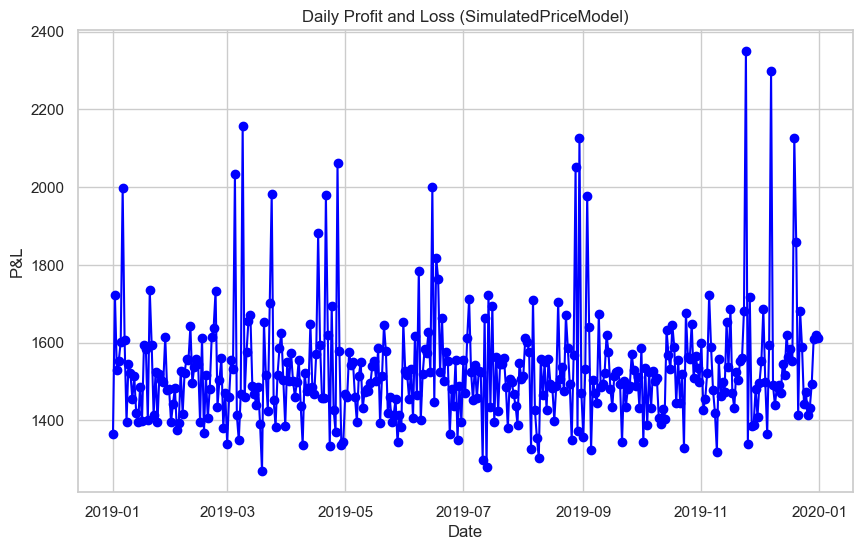

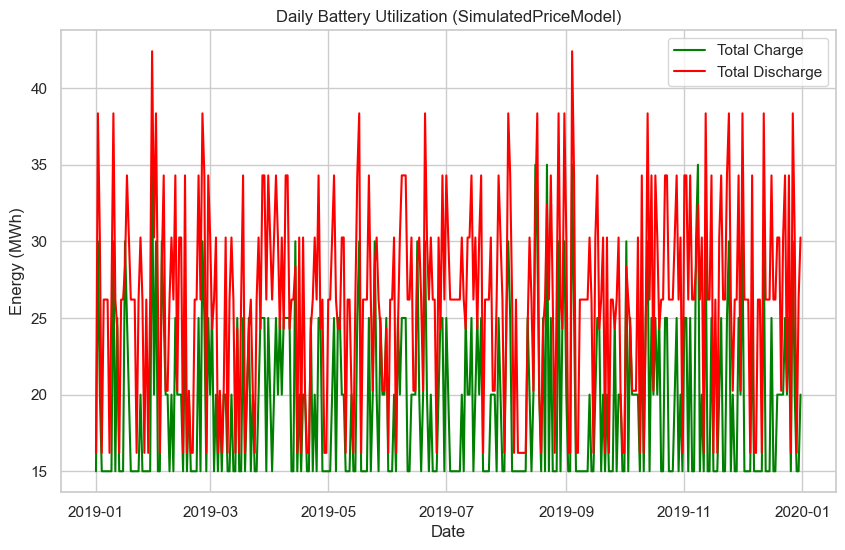

In [5]:
# Run the simulation for the SimulatedPriceModel
PRICE_MODEL = 'SimulatedPriceModel'
results_simulated = run_energy_market_simulator(start_date, end_date, battery_capacity, PRICE_MODEL)
plot_results(results_simulated, PRICE_MODEL)

c:\Users\koula\Documents\GitHub\OpenEnergy\scripts\prices\average_price.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[self.PRICE_COLUMN].interpolate(method="linear", inplace=True)
Processing Days: 100%|██████████| 365/365 [00:29<00:00, 12.20it/s]
2024-06-06 01:40:48,786 - INFO - Total P&L from 2019-01-01 to 2019-12-31: 217715.88869444435


         Daily PnL
count   365.000000
mean    596.481887
std     140.479064
min     317.433111
25%     498.544144
50%     562.164533
75%     687.377778
max    1215.130667


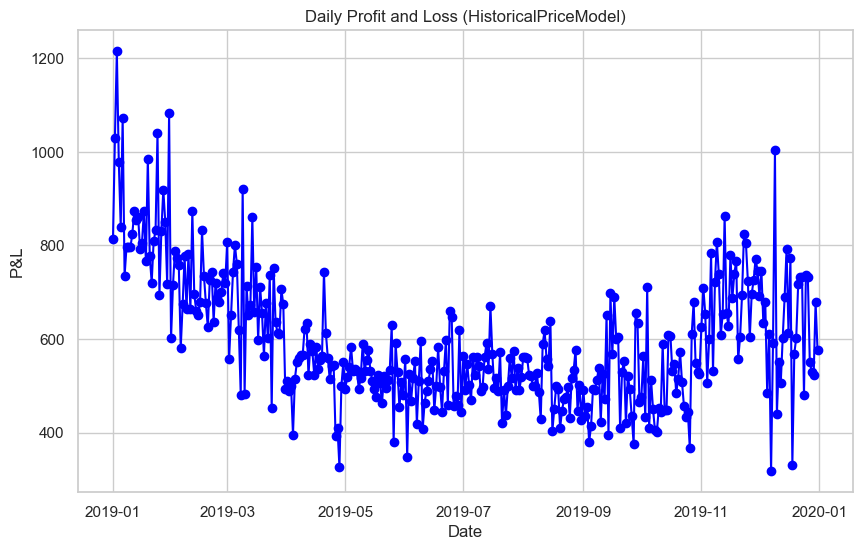

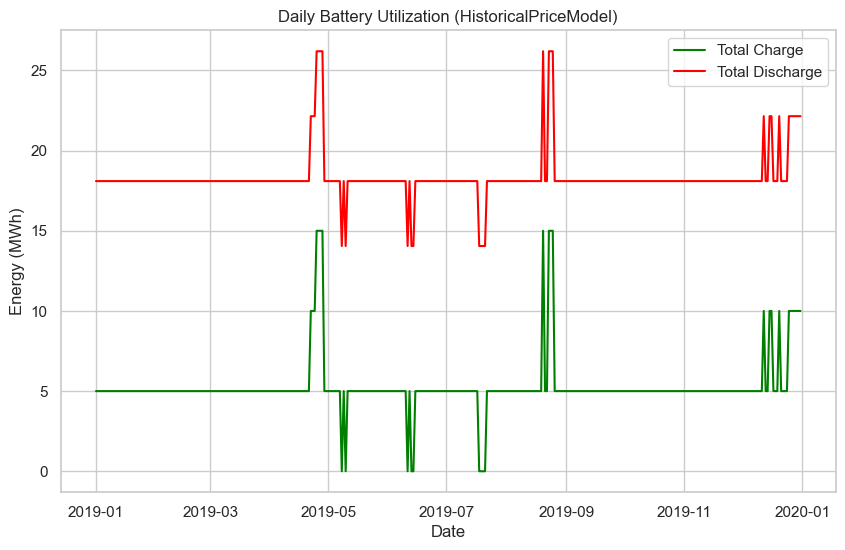

In [6]:
# Run the simulation for the HistoricalPriceModel
PRICE_MODEL = 'HistoricalPriceModel'
results_historical = run_energy_market_simulator(start_date, end_date, battery_capacity, PRICE_MODEL)
plot_results(results_historical, PRICE_MODEL)

c:\Users\koula\Documents\GitHub\OpenEnergy\scripts\prices\forecasted_price.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[self.PRICE_COLUMN].interpolate(method="linear", inplace=True)
Processing Days: 100%|██████████| 365/365 [00:55<00:00,  6.54it/s]
2024-06-06 01:41:47,663 - INFO - Total P&L from 2019-01-01 to 2019-12-31: 207895.83937666676


         Daily PnL
count   365.000000
mean    569.577642
std     143.574571
min     274.171672
25%     472.708961
50%     542.395989
75%     665.019122
max    1215.130667


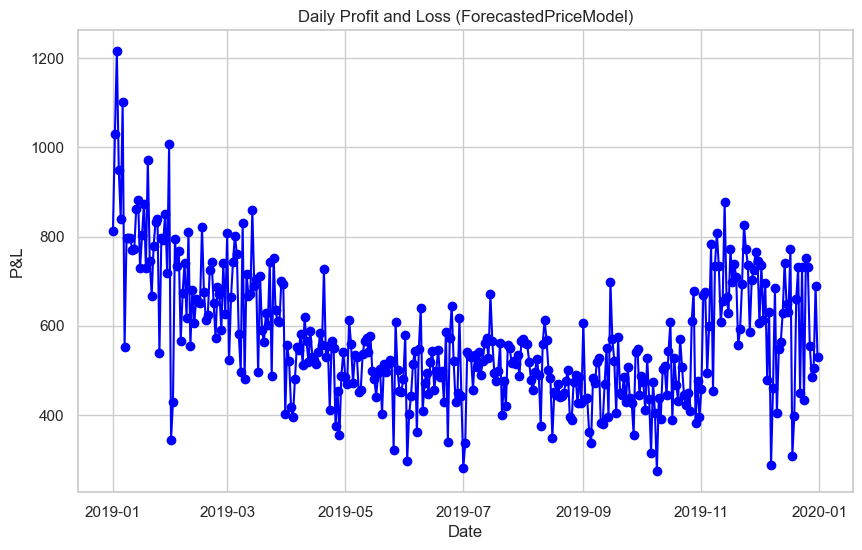

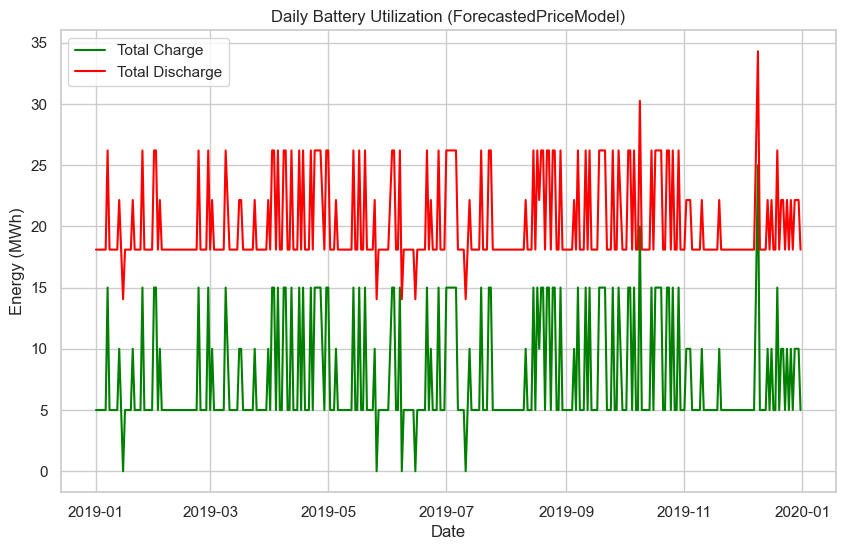

In [7]:
# Run the simulation for the ForecastedPriceModel
PRICE_MODEL = 'ForecastedPriceModel'
results_forecasted = run_energy_market_simulator(start_date, end_date, battery_capacity, PRICE_MODEL)
plot_results(results_forecasted, PRICE_MODEL)